In [ ]:
!pip -q install -U "d3rlpy" "gymnasium" "numpy" "torch" "matplotlib" "scikit-learn"

import os
import time
import random
import inspect
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

import torch
import d3rlpy


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


def pick_device():
    if torch.cuda.is_available():
        return "cuda:0"
    return "cpu"


DEVICE = pick_device()
print("d3rlpy:", getattr(d3rlpy, "__version__", "unknown"), "| torch:", torch.__version__, "| device:", DEVICE)


def make_config(cls, **kwargs):
    sig = inspect.signature(cls.__init__)
    allowed = set(sig.parameters.keys())
    allowed.discard("self")
    filtered = {k: v for k, v in kwargs.items() if k in allowed}
    return cls(**filtered)

In [ ]:
class SafetyCriticalGridWorld(gym.Env):
    metadata = {"render_modes": []}

    def __init__(
        self,
        size=15,
        max_steps=80,
        hazard_coords=None,
        start=(0, 0),
        goal=None,
        slip_prob=0.05,
        seed=0,
    ):
        super().__init__()
        self.size = int(size)
        self.max_steps = int(max_steps)
        self.start = tuple(start)
        self.goal = tuple(goal) if goal is not None else (self.size - 1, self.size - 1)
        self.slip_prob = float(slip_prob)

        if hazard_coords is None:
            hz = set()
            rng = np.random.default_rng(seed)
            for _ in range(max(1, self.size // 2)):
                x = rng.integers(2, self.size - 2)
                y = rng.integers(2, self.size - 2)
                hz.add((int(x), int(y)))
            self.hazards = hz
        else:
            self.hazards = set(tuple(x) for x in hazard_coords)

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0.0, high=float(self.size - 1), shape=(2,), dtype=np.float32)

        self._rng = np.random.default_rng(seed)
        self._pos = None
        self._t = 0

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        self._pos = [int(self.start[0]), int(self.start[1])]
        self._t = 0
        obs = np.array(self._pos, dtype=np.float32)
        return obs, {}

    def _clip(self):
        self._pos[0] = int(np.clip(self._pos[0], 0, self.size - 1))
        self._pos[1] = int(np.clip(self._pos[1], 0, self.size - 1))

    def step(self, action):
        self._t += 1

        a = int(action)
        if self._rng.random() < self.slip_prob:
            a = int(self._rng.integers(0, 4))

        if a == 0:
            self._pos[1] += 1
        elif a == 1:
            self._pos[0] += 1
        elif a == 2:
            self._pos[1] -= 1
        elif a == 3:
            self._pos[0] -= 1

        self._clip()

        x, y = int(self._pos[0]), int(self._pos[1])
        terminated = False
        truncated = self._t >= self.max_steps

        reward = -1.0

        if (x, y) in self.hazards:
            reward = -100.0
            terminated = True

        if (x, y) == self.goal:
            reward = +50.0
            terminated = True

        obs = np.array([x, y], dtype=np.float32)
        return obs, float(reward), terminated, truncated, {}

In [ ]:
def safe_behavior_policy(obs, env: SafetyCriticalGridWorld, epsilon=0.15):
    x, y = int(obs[0]), int(obs[1])
    gx, gy = env.goal

    preferred = []
    if gx > x:
        preferred.append(1)
    elif gx < x:
        preferred.append(3)
    if gy > y:
        preferred.append(0)
    elif gy < y:
        preferred.append(2)

    if len(preferred) == 0:
        preferred = [int(env._rng.integers(0, 4))]

    if env._rng.random() < epsilon:
        return int(env._rng.integers(0, 4))

    candidates = []
    for a in preferred:
        nx, ny = x, y
        if a == 0:
            ny += 1
        elif a == 1:
            nx += 1
        elif a == 2:
            ny -= 1
        elif a == 3:
            nx -= 1
        nx = int(np.clip(nx, 0, env.size - 1))
        ny = int(np.clip(ny, 0, env.size - 1))
        if (nx, ny) not in env.hazards:
            candidates.append(a)

    if len(candidates) == 0:
        return preferred[0]
    return int(random.choice(candidates))


def generate_offline_episodes(env, n_episodes=400, epsilon=0.20, seed=0):
    episodes = []
    for i in range(n_episodes):
        obs, _ = env.reset(seed=int(seed + i))
        obs_list = []
        act_list = []
        rew_list = []
        done_list = []

        done = False
        while not done:
            a = safe_behavior_policy(obs, env, epsilon=epsilon)
            nxt, r, terminated, truncated, _ = env.step(a)
            done = bool(terminated or truncated)

            obs_list.append(np.array(obs, dtype=np.float32))
            act_list.append(np.array([a], dtype=np.int64))
            rew_list.append(np.array([r], dtype=np.float32))
            done_list.append(np.array([1.0 if done else 0.0], dtype=np.float32))

            obs = nxt

        episodes.append(
            {
                "observations": np.stack(obs_list, axis=0),
                "actions": np.stack(act_list, axis=0),
                "rewards": np.stack(rew_list, axis=0),
                "terminals": np.stack(done_list, axis=0),
            }
        )
    return episodes


def build_mdpdataset(episodes):
    obs = np.concatenate([ep["observations"] for ep in episodes], axis=0).astype(np.float32)
    acts = np.concatenate([ep["actions"] for ep in episodes], axis=0).astype(np.int64)
    rews = np.concatenate([ep["rewards"] for ep in episodes], axis=0).astype(np.float32)
    terms = np.concatenate([ep["terminals"] for ep in episodes], axis=0).astype(np.float32)

    if hasattr(d3rlpy, "dataset") and hasattr(d3rlpy.dataset, "MDPDataset"):
        return d3rlpy.dataset.MDPDataset(observations=obs, actions=acts, rewards=rews, terminals=terms)

    raise RuntimeError("d3rlpy.dataset.MDPDataset not found. Upgrade d3rlpy.")

In [ ]:
def _get_episodes_from_dataset(dataset):
    if hasattr(dataset, "episodes") and dataset.episodes is not None:
        return dataset.episodes
    if hasattr(dataset, "get_episodes"):
        return dataset.get_episodes()
    raise AttributeError("Could not find episodes in dataset (d3rlpy version mismatch).")


def _iter_all_observations(dataset):
    for ep in _get_episodes_from_dataset(dataset):
        obs = getattr(ep, "observations", None)
        if obs is None:
            continue
        for o in obs:
            yield o


def _iter_all_transitions(dataset):
    for ep in _get_episodes_from_dataset(dataset):
        obs = getattr(ep, "observations", None)
        acts = getattr(ep, "actions", None)
        rews = getattr(ep, "rewards", None)
        if obs is None or acts is None:
            continue
        n = min(len(obs), len(acts))
        for i in range(n):
            o = obs[i]
            a = acts[i]
            r = rews[i] if rews is not None and i < len(rews) else None
            yield o, a, r


def visualize_dataset(dataset, env, title="Offline Dataset"):
    state_visits = np.zeros((env.size, env.size), dtype=np.float32)
    for obs in _iter_all_observations(dataset):
        x, y = int(obs[0]), int(obs[1])
        x = int(np.clip(x, 0, env.size - 1))
        y = int(np.clip(y, 0, env.size - 1))
        state_visits[y, x] += 1

    plt.figure(figsize=(6, 5))
    plt.imshow(state_visits, origin="lower")
    plt.colorbar(label="Visits")
    plt.scatter([env.start[0]], [env.start[1]], marker="o", label="start")
    plt.scatter([env.goal[0]], [env.goal[1]], marker="*", label="goal")
    if len(env.hazards) > 0:
        hz = np.array(list(env.hazards), dtype=np.int32)
        plt.scatter(hz[:, 0], hz[:, 1], marker="x", label="hazards")
    plt.title(f"{title} — State visitation")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    rewards = []
    for _, _, r in _iter_all_transitions(dataset):
        if r is not None:
            rewards.append(float(r))
    if len(rewards) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(rewards, bins=60)
        plt.title(f"{title} — Reward distribution")
        plt.xlabel("reward")
        plt.ylabel("count")
        plt.show()

In [ ]:
def rollout_eval(env, algo, n_episodes=25, seed=0):
    returns = []
    lengths = []
    hazard_hits = 0
    goal_hits = 0

    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed + i)
        done = False
        total = 0.0
        steps = 0
        while not done:
            a = int(algo.predict(np.asarray(obs, dtype=np.float32)[None, ...])[0])
            obs, r, terminated, truncated, _ = env.step(a)
            total += float(r)
            steps += 1
            done = bool(terminated or truncated)
            if terminated:
                x, y = int(obs[0]), int(obs[1])
                if (x, y) in env.hazards:
                    hazard_hits += 1
                if (x, y) == env.goal:
                    goal_hits += 1

        returns.append(total)
        lengths.append(steps)

    return {
        "return_mean": float(np.mean(returns)),
        "return_std": float(np.std(returns)),
        "len_mean": float(np.mean(lengths)),
        "hazard_rate": float(hazard_hits / max(1, n_episodes)),
        "goal_rate": float(goal_hits / max(1, n_episodes)),
        "returns": np.asarray(returns, dtype=np.float32),
    }


def action_mismatch_rate_vs_data(dataset, algo, sample_obs=7000, seed=0):
    rng = np.random.default_rng(seed)
    obs_all = []
    act_all = []
    for o, a, _ in _iter_all_transitions(dataset):
        obs_all.append(np.asarray(o, dtype=np.float32))
        act_all.append(int(np.asarray(a).reshape(-1)[0]))
        if len(obs_all) >= 80_000:
            break

    obs_all = np.stack(obs_all, axis=0)
    act_all = np.asarray(act_all, dtype=np.int64)

    idx = rng.choice(len(obs_all), size=min(sample_obs, len(obs_all)), replace=False)
    obs_probe = obs_all[idx]
    act_probe_data = act_all[idx]
    act_probe_pi = algo.predict(obs_probe).astype(np.int64)

    mismatch = (act_probe_pi != act_probe_data).astype(np.float32)
    return float(mismatch.mean())


def create_discrete_bc(device):
    if hasattr(d3rlpy.algos, "DiscreteBCConfig"):
        cls = d3rlpy.algos.DiscreteBCConfig
        cfg = make_config(
            cls,
            learning_rate=3e-4,
            batch_size=256,
        )
        return cfg.create(device=device)
    if hasattr(d3rlpy.algos, "DiscreteBC"):
        return d3rlpy.algos.DiscreteBC()
    raise RuntimeError("DiscreteBC not available in this d3rlpy version.")


def create_discrete_cql(device, conservative_weight=6.0):
    if hasattr(d3rlpy.algos, "DiscreteCQLConfig"):
        cls = d3rlpy.algos.DiscreteCQLConfig
        cfg = make_config(
            cls,
            learning_rate=3e-4,
            actor_learning_rate=3e-4,
            critic_learning_rate=3e-4,
            temp_learning_rate=3e-4,
            alpha_learning_rate=3e-4,
            batch_size=256,
            conservative_weight=float(conservative_weight),
            n_action_samples=10,
            rollout_interval=0,
        )
        return cfg.create(device=device)
    if hasattr(d3rlpy.algos, "DiscreteCQL"):
        algo = d3rlpy.algos.DiscreteCQL()
        if hasattr(algo, "conservative_weight"):
            try:
                algo.conservative_weight = float(conservative_weight)
            except Exception:
                pass
        return algo
    raise RuntimeError("DiscreteCQL not available in this d3rlpy version.")

d3rlpy: 2.8.1 | torch: 2.9.0+cpu | device: cpu
2026-01-10 16:45.33 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(2,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2026-01-10 16:45.33 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2026-01-10 16:45.33 [info     ] Action size has been automatically determined. action_size=4
dataset built: MDPDataset


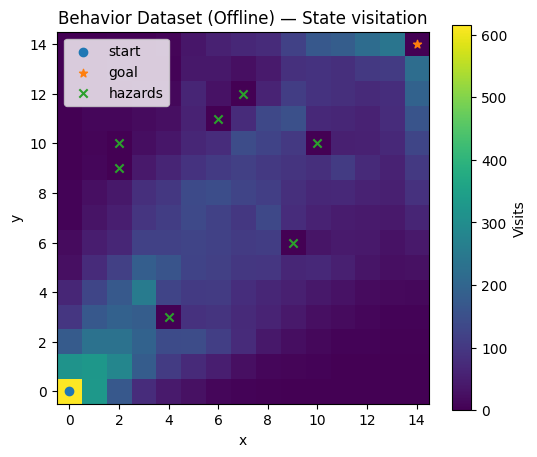

/tmp/ipython-input-1237901326.py:278: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards.append(float(r))


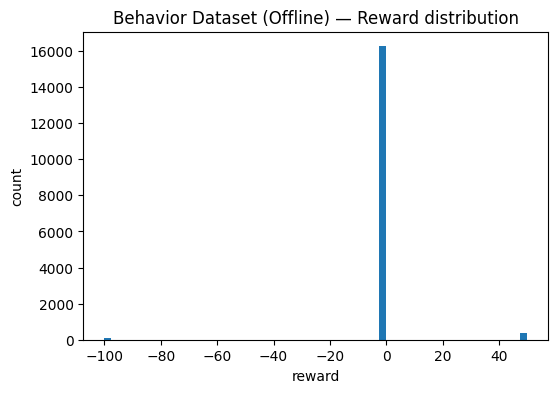


Training Discrete BC (offline)...
2026-01-10 16:45.34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(2,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=4)
2026-01-10 16:45.34 [debug    ] Building models...            
2026-01-10 16:45.39 [debug    ] Models have been built.       
2026-01-10 16:45.39 [info     ] Directory is created at d3rlpy_logs/grid_bc_offline_20260110164539
2026-01-10 16:45.39 [info     ] Parameters                     params={'observation_shape': [2], 'action_size': 4, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0.0

Epoch 1/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:46.09 [info     ] grid_bc_offline_20260110164539: epoch=1 step=2500 epoch=1 metrics={'time_sample_batch': 0.005204692363739014, 'time_algorithm_update': 0.006374246120452881, 'loss': 2.2510122184753416, 'imitation_loss': 1.2160427954673767, 'regularization_loss': 1.0349694234848021, 'time_step': 0.011700427436828613} step=2500
2026-01-10 16:46.09 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_2500.d3


Epoch 2/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:46.37 [info     ] grid_bc_offline_20260110164539: epoch=2 step=5000 epoch=2 metrics={'time_sample_batch': 0.005009008502960205, 'time_algorithm_update': 0.006278664588928223, 'loss': 2.243166466617584, 'imitation_loss': 1.2081592307567597, 'regularization_loss': 1.0350072353363038, 'time_step': 0.011400607681274414} step=5000
2026-01-10 16:46.37 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_5000.d3


Epoch 3/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:47.06 [info     ] grid_bc_offline_20260110164539: epoch=3 step=7500 epoch=3 metrics={'time_sample_batch': 0.005009394359588623, 'time_algorithm_update': 0.006343817710876465, 'loss': 2.2401930583000182, 'imitation_loss': 1.2043693332195282, 'regularization_loss': 1.0358237250328064, 'time_step': 0.011465524196624756} step=7500
2026-01-10 16:47.06 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_7500.d3


Epoch 4/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:47.36 [info     ] grid_bc_offline_20260110164539: epoch=4 step=10000 epoch=4 metrics={'time_sample_batch': 0.0051243564605712895, 'time_algorithm_update': 0.006532163524627686, 'loss': 2.2390618085861207, 'imitation_loss': 1.2033527052402497, 'regularization_loss': 1.035709104204178, 'time_step': 0.011788251972198486} step=10000
2026-01-10 16:47.36 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_10000.d3


Epoch 5/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:48.05 [info     ] grid_bc_offline_20260110164539: epoch=5 step=12500 epoch=5 metrics={'time_sample_batch': 0.005020024108886719, 'time_algorithm_update': 0.006439903163909912, 'loss': 2.237081265068054, 'imitation_loss': 1.2006943418979645, 'regularization_loss': 1.0363869238376617, 'time_step': 0.011575561809539794} step=12500
2026-01-10 16:48.05 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_12500.d3


Epoch 6/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:48.35 [info     ] grid_bc_offline_20260110164539: epoch=6 step=15000 epoch=6 metrics={'time_sample_batch': 0.00514315128326416, 'time_algorithm_update': 0.006624722003936768, 'loss': 2.235940691757202, 'imitation_loss': 1.1989967684268952, 'regularization_loss': 1.0369439235687257, 'time_step': 0.011887865543365479} step=15000
2026-01-10 16:48.35 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_15000.d3


Epoch 7/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:49.05 [info     ] grid_bc_offline_20260110164539: epoch=7 step=17500 epoch=7 metrics={'time_sample_batch': 0.005136110591888427, 'time_algorithm_update': 0.00662126579284668, 'loss': 2.234892980003357, 'imitation_loss': 1.1973387828826905, 'regularization_loss': 1.0375541947841644, 'time_step': 0.011873729991912841} step=17500
2026-01-10 16:49.05 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_17500.d3


Epoch 8/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:49.35 [info     ] grid_bc_offline_20260110164539: epoch=8 step=20000 epoch=8 metrics={'time_sample_batch': 0.004995276355743409, 'time_algorithm_update': 0.006545702266693115, 'loss': 2.2337053231239317, 'imitation_loss': 1.1953194261074067, 'regularization_loss': 1.0383858957767487, 'time_step': 0.011662033557891846} step=20000
2026-01-10 16:49.35 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_20000.d3


Epoch 9/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:50.05 [info     ] grid_bc_offline_20260110164539: epoch=9 step=22500 epoch=9 metrics={'time_sample_batch': 0.00516397008895874, 'time_algorithm_update': 0.006727023696899414, 'loss': 2.2337191997528074, 'imitation_loss': 1.1953347141265869, 'regularization_loss': 1.0383844863891603, 'time_step': 0.012021430683135987} step=22500
2026-01-10 16:50.05 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_22500.d3


Epoch 10/10:   0%|          | 0/2500 [00:00<?, ?it/s]

2026-01-10 16:50.35 [info     ] grid_bc_offline_20260110164539: epoch=10 step=25000 epoch=10 metrics={'time_sample_batch': 0.005089842414855957, 'time_algorithm_update': 0.0066932226181030275, 'loss': 2.232941889381409, 'imitation_loss': 1.1939431707382202, 'regularization_loss': 1.0389987186431884, 'time_step': 0.011903003787994386} step=25000
2026-01-10 16:50.35 [info     ] Model parameters are saved to d3rlpy_logs/grid_bc_offline_20260110164539/model_25000.d3
BC train sec: 301.11

Training Discrete CQL (offline)...
2026-01-10 16:50.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(2,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=4)
2026-01-10 16:50.35 [debug    ] Building models...            
2026-01-10 16:50.35 [debug    ] Models have been built.       


Epoch 1/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 16:52.56 [info     ] grid_cql_offline_20260110165035: epoch=1 step=8000 epoch=1 metrics={'time_sample_batch': 0.005123282700777053, 'time_algorithm_update': 0.012108146578073502, 'loss': 2.9656922301352022, 'td_loss': 1.9128119795173406, 'conservative_loss': 1.0528802482038737, 'time_step': 0.01744101282954216} step=8000
2026-01-10 16:52.56 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_8000.d3


Epoch 2/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 16:55.17 [info     ] grid_cql_offline_20260110165035: epoch=2 step=16000 epoch=2 metrics={'time_sample_batch': 0.005085179418325424, 'time_algorithm_update': 0.012167478978633881, 'loss': 2.82742470921576, 'td_loss': 1.7709894955903291, 'conservative_loss': 1.0564352133572101, 'time_step': 0.017462731391191484} step=16000
2026-01-10 16:55.17 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_16000.d3


Epoch 3/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 16:57.37 [info     ] grid_cql_offline_20260110165035: epoch=3 step=24000 epoch=3 metrics={'time_sample_batch': 0.0050026865005493165, 'time_algorithm_update': 0.012144631028175354, 'loss': 2.4514755492806435, 'td_loss': 1.2893332608956845, 'conservative_loss': 1.1621422883421182, 'time_step': 0.01735375639796257} step=24000
2026-01-10 16:57.37 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_24000.d3


Epoch 4/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:00.01 [info     ] grid_cql_offline_20260110165035: epoch=4 step=32000 epoch=4 metrics={'time_sample_batch': 0.005156533986330032, 'time_algorithm_update': 0.012526895135641099, 'loss': 2.382795074775815, 'td_loss': 1.2131263941470534, 'conservative_loss': 1.1696686800569296, 'time_step': 0.017893394857645035} step=32000
2026-01-10 17:00.01 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_32000.d3


Epoch 5/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:02.25 [info     ] grid_cql_offline_20260110165035: epoch=5 step=40000 epoch=5 metrics={'time_sample_batch': 0.0050874315202236176, 'time_algorithm_update': 0.012488414853811265, 'loss': 2.332027840271592, 'td_loss': 1.2305075651854276, 'conservative_loss': 1.1015202758684755, 'time_step': 0.017785149455070495} step=40000
2026-01-10 17:02.25 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_40000.d3


Epoch 6/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:04.48 [info     ] grid_cql_offline_20260110165035: epoch=6 step=48000 epoch=6 metrics={'time_sample_batch': 0.0051000892221927645, 'time_algorithm_update': 0.012439703226089477, 'loss': 2.4279560487568377, 'td_loss': 1.3550313094817101, 'conservative_loss': 1.0729247385039926, 'time_step': 0.01774848198890686} step=48000
2026-01-10 17:04.48 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_48000.d3


Epoch 7/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:07.10 [info     ] grid_cql_offline_20260110165035: epoch=7 step=56000 epoch=7 metrics={'time_sample_batch': 0.0049783935546875, 'time_algorithm_update': 0.012363723009824752, 'loss': 2.4517233240455387, 'td_loss': 1.3982992771230638, 'conservative_loss': 1.0534240454286337, 'time_step': 0.01754788038134575} step=56000
2026-01-10 17:07.10 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_56000.d3


Epoch 8/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:09.35 [info     ] grid_cql_offline_20260110165035: epoch=8 step=64000 epoch=8 metrics={'time_sample_batch': 0.005016562640666962, 'time_algorithm_update': 0.01277905237674713, 'loss': 2.445066973239183, 'td_loss': 1.3800607245378196, 'conservative_loss': 1.0650062502771616, 'time_step': 0.018006190598011017} step=64000
2026-01-10 17:09.35 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_64000.d3


Epoch 9/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:12.02 [info     ] grid_cql_offline_20260110165035: epoch=9 step=72000 epoch=9 metrics={'time_sample_batch': 0.0050167724788188935, 'time_algorithm_update': 0.013021940737962723, 'loss': 2.4094552079588176, 'td_loss': 1.3353779897131026, 'conservative_loss': 1.0740772175639868, 'time_step': 0.018246998012065887} step=72000
2026-01-10 17:12.02 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_72000.d3


Epoch 10/10:   0%|          | 0/8000 [00:00<?, ?it/s]

2026-01-10 17:14.31 [info     ] grid_cql_offline_20260110165035: epoch=10 step=80000 epoch=10 metrics={'time_sample_batch': 0.0050466468930244444, 'time_algorithm_update': 0.01322178691625595, 'loss': 2.3269537243694067, 'td_loss': 1.2368257169760764, 'conservative_loss': 1.0901280066519976, 'time_step': 0.01847637513279915} step=80000
2026-01-10 17:14.31 [info     ] Model parameters are saved to d3rlpy_logs/grid_cql_offline_20260110165035/model_80000.d3
CQL train sec: 1436.12

Controlled online evaluation (small number of rollouts):
BC : {'return_mean': 16.533333333333335, 'return_std': 25.056912995995507, 'len_mean': 29.466666666666665, 'hazard_rate': 0.03333333333333333, 'goal_rate': 0.9666666666666667}
CQL: {'return_mean': 21.133333333333333, 'return_std': 1.8208667044996885, 'len_mean': 29.866666666666667, 'hazard_rate': 0.0, 'goal_rate': 1.0}

OOD-ish diagnostic (policy action mismatch vs data action at same states):
BC mismatch rate : 0.46700000762939453
CQL mismatch rate: 0.463

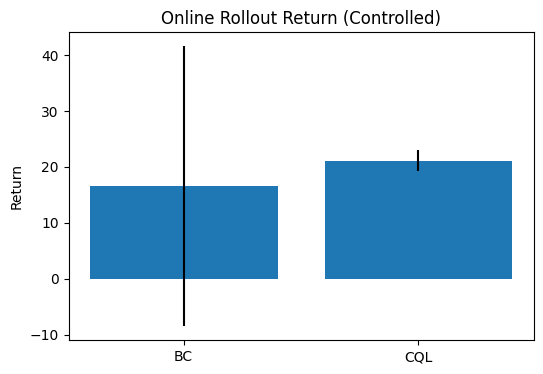

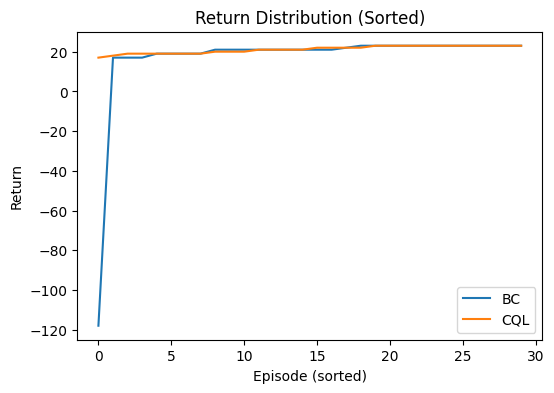

Saved BC policy: /content/offline_rl_artifacts/grid_bc_policy.pt
Saved CQL policy: /content/offline_rl_artifacts/grid_cql_policy.pt

Done.


In [3]:
def main():
    env = SafetyCriticalGridWorld(
        size=15,
        max_steps=80,
        slip_prob=0.05,
        seed=SEED,
    )

    raw_eps = generate_offline_episodes(env, n_episodes=500, epsilon=0.22, seed=SEED)
    dataset = build_mdpdataset(raw_eps)

    print("dataset built:", type(dataset).__name__)
    visualize_dataset(dataset, env, title="Behavior Dataset (Offline)")

    bc = create_discrete_bc(DEVICE)
    cql = create_discrete_cql(DEVICE, conservative_weight=6.0)

    print("\nTraining Discrete BC (offline)...")
    t0 = time.time()
    bc.fit(
        dataset,
        n_steps=25_000,
        n_steps_per_epoch=2_500,
        experiment_name="grid_bc_offline",
    )
    print("BC train sec:", round(time.time() - t0, 2))

    print("\nTraining Discrete CQL (offline)...")
    t0 = time.time()
    cql.fit(
        dataset,
        n_steps=80_000,
        n_steps_per_epoch=8_000,
        experiment_name="grid_cql_offline",
    )
    print("CQL train sec:", round(time.time() - t0, 2))

    print("\nControlled online evaluation (small number of rollouts):")
    bc_metrics = rollout_eval(env, bc, n_episodes=30, seed=SEED + 1000)
    cql_metrics = rollout_eval(env, cql, n_episodes=30, seed=SEED + 2000)

    print("BC :", {k: v for k, v in bc_metrics.items() if k != "returns"})
    print("CQL:", {k: v for k, v in cql_metrics.items() if k != "returns"})

    print("\nOOD-ish diagnostic (policy action mismatch vs data action at same states):")
    bc_mismatch = action_mismatch_rate_vs_data(dataset, bc, sample_obs=7000, seed=SEED + 1)
    cql_mismatch = action_mismatch_rate_vs_data(dataset, cql, sample_obs=7000, seed=SEED + 2)
    print("BC mismatch rate :", bc_mismatch)
    print("CQL mismatch rate:", cql_mismatch)

    plt.figure(figsize=(6, 4))
    labels = ["BC", "CQL"]
    means = [bc_metrics["return_mean"], cql_metrics["return_mean"]]
    stds = [bc_metrics["return_std"], cql_metrics["return_std"]]
    plt.bar(labels, means, yerr=stds)
    plt.ylabel("Return")
    plt.title("Online Rollout Return (Controlled)")
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(np.sort(bc_metrics["returns"]), label="BC")
    plt.plot(np.sort(cql_metrics["returns"]), label="CQL")
    plt.xlabel("Episode (sorted)")
    plt.ylabel("Return")
    plt.title("Return Distribution (Sorted)")
    plt.legend()
    plt.show()

    out_dir = "/content/offline_rl_artifacts"
    os.makedirs(out_dir, exist_ok=True)
    bc_path = os.path.join(out_dir, "grid_bc_policy.pt")
    cql_path = os.path.join(out_dir, "grid_cql_policy.pt")

    if hasattr(bc, "save_policy"):
        bc.save_policy(bc_path)
        print("Saved BC policy:", bc_path)
    if hasattr(cql, "save_policy"):
        cql.save_policy(cql_path)
        print("Saved CQL policy:", cql_path)

    print("\nDone.")


if __name__ == "__main__":
    main()